In [1]:
# gmm, pyclust, r-mclust
# simulation

import math
import networkx as nx
import graspy
import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.plot import heatmap, pairplot
from graspy.cluster.pyclust import PyclustCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.sparse.linalg import eigsh 
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib inline

In [2]:
## #####  rpy2 stuff  ######
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
# R package names
packnames = ('mclust')
utils = rpackages.importr('utils')
base = rpackages.importr('base')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))

mclust = rpackages.importr('mclust',lib_loc ="D:/Program Files/R/R-3.6.1/library")
## new def for R's mclust
def cluster_gmm(E):
    nr,nc = E.shape
    Er = robjects.r.matrix(E, nrow=nr, ncol=nc)
    robjects.r.assign("E", Er)
    mc = mclust.Mclust(Er, G=2, verbose=0)
    Y = mc.rx2("classification")
    return np.array(Y, dtype=np.uint8) - 1


In [3]:
# generate single SBM graph
np.random.seed(3000)

n_verts = 800
labels_sbm = int(0.28 * n_verts) * ["LG"] + int(0.22 * n_verts) * ["LW"] + int(0.28 * n_verts) * ["RG"] + int(0.22 * n_verts) * ["RW"]
labels_lr = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [0] + int(0.28*n_verts) * [1] + int(0.22*n_verts) * [1] #true label
labels_gw = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [1] + int(0.28*n_verts) * [0] + int(0.22*n_verts) * [1] #true label
n_verts = int(0.28 * n_verts) + int(0.22*n_verts) + int(0.28*n_verts) + int(0.22*n_verts)

P = np.array(
	[[0.018932108, 0.042869173, 0.002084243, 0.008436194],
	[0.042869173, 0.112538688, 0.009629583, 0.040333219],
	[0.002084243, 0.009629583, 0.019360040, 0.044269707],
	[0.008436194, 0.040333219, 0.044269707, 0.115217630	]])

undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)

In [4]:
# ASE & LSE
ase = AdjacencySpectralEmbed()
ase_Xhat = ase.fit_transform(undirected_sbm)
lse = LaplacianSpectralEmbed()
lse_Xhat = lse.fit_transform(undirected_sbm)

ARI(ASE,LR):  0.9850375236134279
ARI(ASE,GW):  -0.0012288902064919057
ARI(LSE,LR):  0.9900125
ARI(LSE,GW):  -0.0012100345557675043


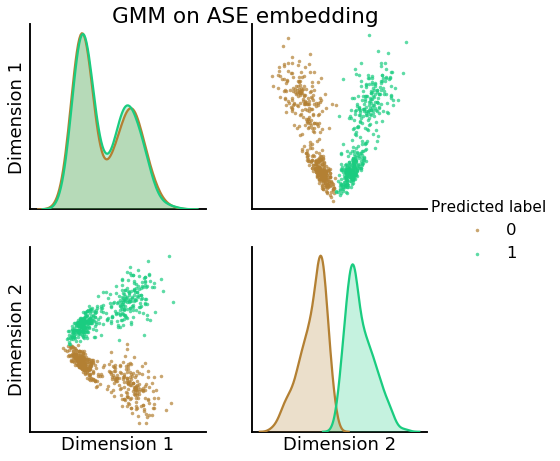

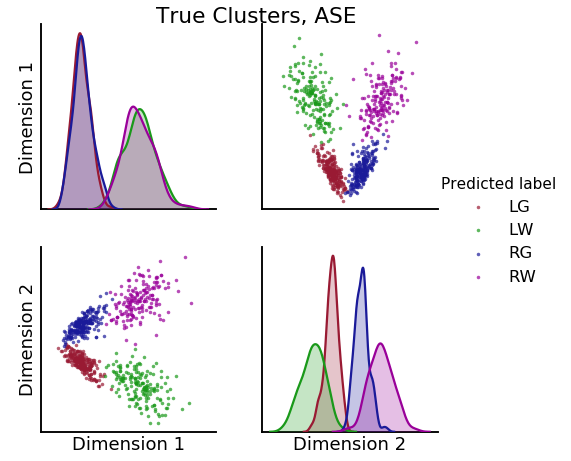

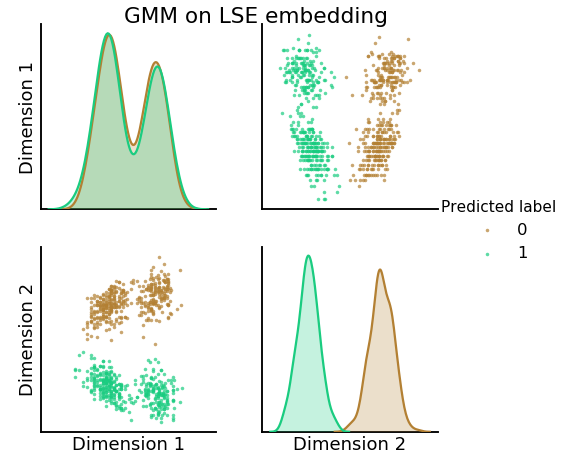

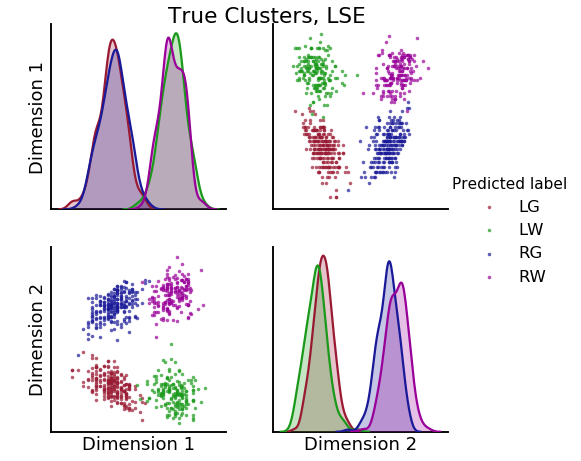

In [5]:
# Python- GMM
palette_pre = {0:(0.7,0.5,0.2),
           1:(0.1,0.8,0.5)}
palette_true = {'LG':(0.6,0.1,0.2),
                'LW':(0.1,0.6,0.1),
                'RG':(0.1,0.1,0.6),
                'RW':(0.6,0,0.6)}
#ASE
gmm_ase = GaussianMixture(n_components=2).fit(ase_Xhat)
ase_gmm = gmm_ase.predict(ase_Xhat)

ase_ari = adjusted_rand_score(labels_lr, ase_gmm)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_gmm)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)

pairplot(ase_Xhat,
         labels=ase_gmm,
         title='GMM on ASE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(ase_Xhat,
         labels=labels_sbm,
         title='True Clusters, ASE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

#LSE
gmm_lse = GaussianMixture(n_components=2).fit(lse_Xhat)
lse_gmm = gmm_lse.predict(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_gmm)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_gmm)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_gmm,
         title='GMM on LSE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(lse_Xhat,
         labels=labels_sbm,
         title='True Clusters, LSE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

ARI(ASE,LR):  0.9850375236134279
ARI(ASE,GW):  -0.0012288902064919057
ARI(LSE,LR):  0.9900125
ARI(LSE,GW):  -0.0012100345557675043


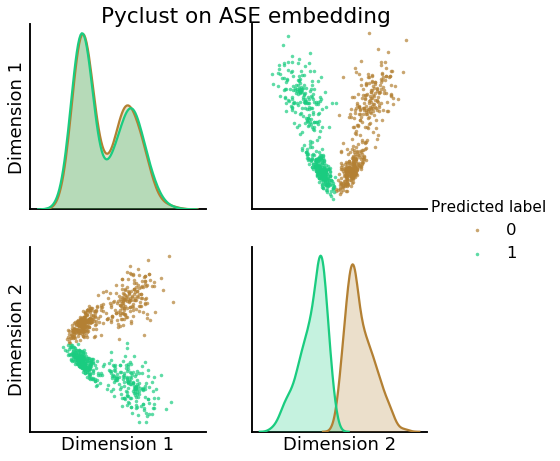

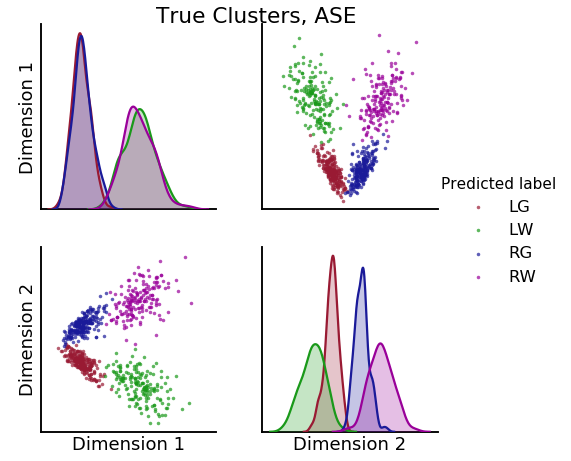

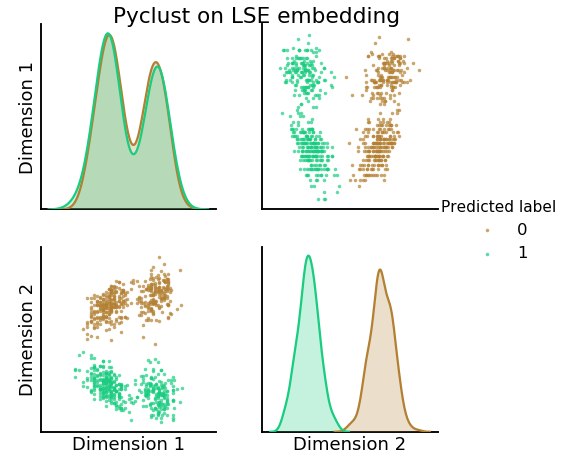

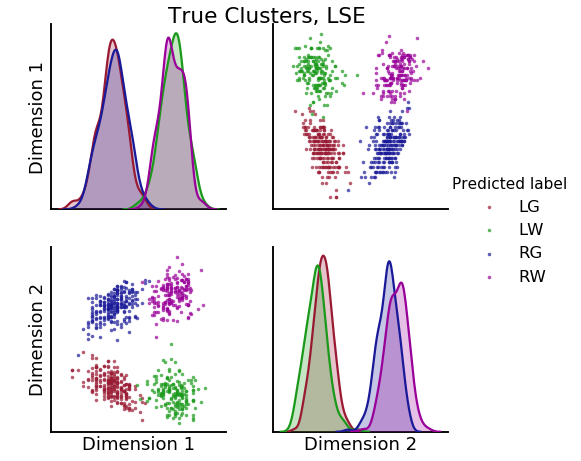

In [6]:
# Python- Pyclust

#ASE
py_ase = PyclustCluster(max_components=2).fit(ase_Xhat)
ase_py = py_ase.predict(ase_Xhat)

ase_ari = adjusted_rand_score(labels_lr, ase_py)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_py)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)

pairplot(ase_Xhat,
         labels=ase_py,
         title='Pyclust on ASE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(ase_Xhat,
         labels=labels_sbm,
         title='True Clusters, ASE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

#LSE
py_lse = PyclustCluster(max_components=2).fit(lse_Xhat)
lse_py = py_lse.predict(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_py)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_py)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_py,
         title='Pyclust on LSE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(lse_Xhat,
         labels=labels_sbm,
         title='True Clusters, LSE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

ARI(ASE,LR):  -0.0010198226480389314
ARI(ASE,GW):  0.9214965475805392
ARI(LSE,LR):  0.9900125
ARI(LSE,GW):  -0.0012100345557675043


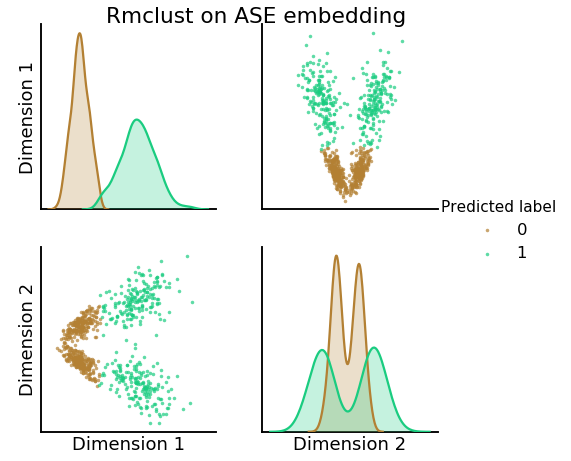

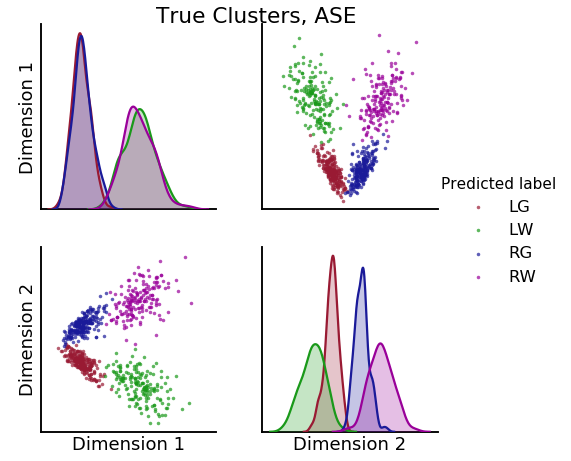

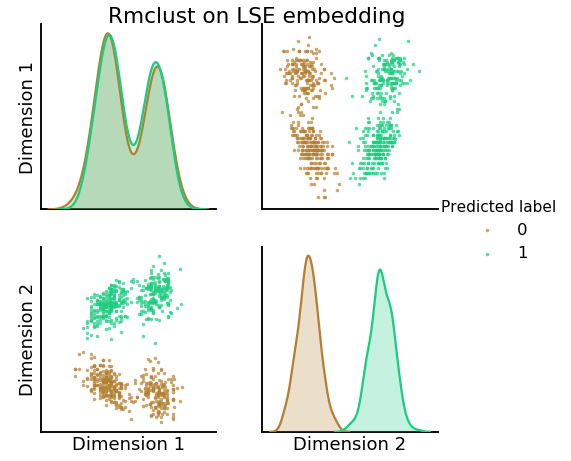

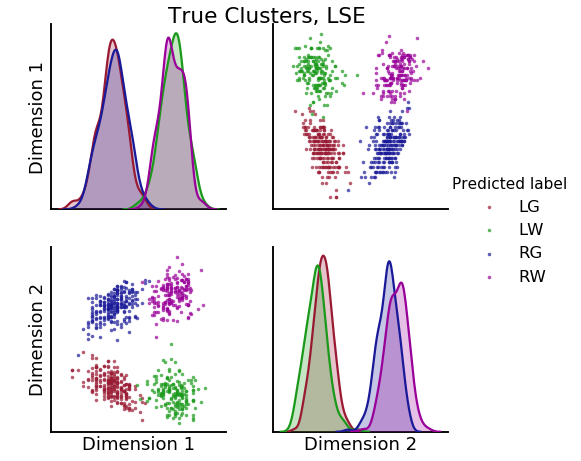

In [7]:
# R-mclust

#ASE
ase_rm = cluster_gmm(ase_Xhat)

ase_ari = adjusted_rand_score(labels_lr, ase_rm)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_rm)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)

pairplot(ase_Xhat,
         labels=ase_rm,
         title='Rmclust on ASE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(ase_Xhat,
         labels=labels_sbm,
         title='True Clusters, ASE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

#LSE
lse_rm = cluster_gmm(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_rm)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_rm)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_rm,
         title='Rmclust on LSE embedding',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_pre)
pairplot(lse_Xhat,
         labels=labels_sbm,
         title='True Clusters, LSE',
         legend_name='Predicted label',
         height=3.5,
         palette= palette_true)

In [8]:
# multi-graph

times=20
ARI_ASE=np.zeros((times,6))
ARI_LSE=np.zeros((times,6))

for i in range(times):
    undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)
    #ASE
    ase = AdjacencySpectralEmbed()
    ase_Xhat = ase.fit_transform(undirected_sbm)
    
    #GMM
    gmm_ase = GaussianMixture(n_components=2).fit(ase_Xhat)
    ase_gmm = gmm_ase.predict(ase_Xhat)
    ARI_ASE[i,0] = adjusted_rand_score(labels_lr, ase_gmm)
    ARI_ASE[i,1]  = adjusted_rand_score(labels_gw, ase_gmm)
    #pyclust
    py_ase = PyclustCluster(max_components=2).fit(ase_Xhat)
    ase_py = py_ase.predict(ase_Xhat)
    ARI_ASE[i,2] = adjusted_rand_score(labels_lr, ase_py)
    ARI_ASE[i,3] = adjusted_rand_score(labels_gw, ase_py)
    #R-mclust
    ase_rm = cluster_gmm(ase_Xhat)
    ARI_ASE[i,4] = adjusted_rand_score(labels_lr, ase_rm)
    ARI_ASE[i,5] = adjusted_rand_score(labels_gw, ase_rm)
    
    #LSE
    lse = LaplacianSpectralEmbed()
    lse_Xhat = lse.fit_transform(undirected_sbm)
    #gmm
    gmm_lse = GaussianMixture(n_components=2).fit(lse_Xhat)
    lse_gmm = gmm_lse.predict(lse_Xhat)
    ARI_LSE[i,0] = adjusted_rand_score(labels_lr, lse_gmm)
    ARI_LSE[i,1] = adjusted_rand_score(labels_gw, lse_gmm)
    #pyclust
    py_lse = PyclustCluster(max_components=2).fit(lse_Xhat)
    lse_py = py_lse.predict(lse_Xhat)
    ARI_LSE[i,2] = adjusted_rand_score(labels_lr, lse_py)
    ARI_LSE[i,3] = adjusted_rand_score(labels_gw, lse_py)
    #R-mclust
    lse_rm = cluster_gmm(lse_Xhat)
    ARI_LSE[i,4] = adjusted_rand_score(labels_lr, lse_rm)
    ARI_LSE[i,5] = adjusted_rand_score(labels_gw, lse_rm)


In [9]:
print("ASE:")
print("gmm_lr gmm_gw py_lr py_gw rm_lr rm_gw")
print(np.around(ARI_ASE, decimals=2))

ASE:
gmm_lr gmm_gw py_lr py_gw rm_lr rm_gw
[[ 0.99 -0.    0.99 -0.   -0.    0.95]
 [ 0.99 -0.    0.99 -0.   -0.    0.94]
 [ 0.99 -0.    0.99 -0.   -0.    0.93]
 [ 0.99 -0.    0.99 -0.   -0.    0.93]
 [ 0.97 -0.    0.97 -0.   -0.    0.97]
 [ 0.99 -0.    0.99 -0.   -0.    0.95]
 [ 0.99 -0.    0.99 -0.   -0.    0.98]
 [ 0.96 -0.    0.96 -0.   -0.    0.94]
 [ 0.99 -0.    0.99 -0.   -0.    0.96]
 [ 0.99 -0.    0.99 -0.   -0.    0.95]
 [ 0.98 -0.    0.98 -0.   -0.    0.99]
 [ 0.98 -0.    0.98 -0.   -0.    0.94]
 [ 0.99 -0.    0.99 -0.   -0.    0.97]
 [ 1.   -0.    1.   -0.   -0.    0.95]
 [ 0.98 -0.    0.98 -0.   -0.    0.94]
 [ 0.98 -0.    0.98 -0.   -0.    0.95]
 [ 0.99 -0.    0.99 -0.   -0.    0.94]
 [ 0.98 -0.    0.98 -0.   -0.    0.94]
 [ 0.99 -0.    0.99 -0.   -0.    0.92]
 [ 0.99 -0.    0.99 -0.   -0.    0.96]]


In [10]:
print("LSE:")
print("gmm_lr gmm_gw py_lr py_gw rm_lr rm_gw")
print(np.around(ARI_LSE, decimals=2))

LSE:
gmm_lr gmm_gw py_lr py_gw rm_lr rm_gw
[[ 1.   -0.    1.   -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 1.   -0.    1.   -0.    1.   -0.  ]
 [ 1.   -0.    1.   -0.    1.   -0.  ]
 [ 0.98 -0.    0.98 -0.    0.98 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 1.   -0.    1.   -0.    0.99 -0.  ]
 [ 0.98 -0.    0.98 -0.    0.98 -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 1.   -0.    1.   -0.    1.   -0.  ]
 [ 0.99 -0.    0.99 -0.    0.99 -0.  ]
 [ 1.   -0.    1.   -0.    1.   -0.  ]
 [ 0.99 -0.    0.99 -0.    1.   -0.  ]]
